# Technical Assignment for Data Scientist position at BEES (AB InBev)

# Environment setup

## Dependencies

In [1]:
%load_ext cudf.pandas

# IO
import duckdb
import os
import gc

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities
from matplotlib_venn import venn2, venn3
from typing import Sequence, Optional
from itertools import combinations

# Clustering
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from clustergram import Clustergram

## Global variables

In [2]:
DB_FILE = 'ambev.db'
DATA_DIR = 'online-shopping-dataset/'

# Utility functions

In [3]:
# Function to create and load a table
def create_and_load_table(conn, file_name, table_name):
    # Drop the table if it exists
    conn.execute(f"DROP TABLE IF EXISTS {table_name}")

    # Read the CSV file to infer the schema
    conn.execute(f"CRCEATE TABLE {table_name} AS SELECT * FROM read_csv_auto('{file_name}', header=true, sample_size=-1)")
    print(f"Table {table_name} created and loaded from {file_name}")



def compare_series(*series: Sequence, labels: Optional[Sequence[str]] = None, title: Optional[str] = None):
    n_series = len(series)
    if n_series not in (2, 3):
        raise ValueError("Function supports comparison of 2 or 3 series only.")

    labels = labels or [f'Series {i+1}' for i in range(n_series)]
    if len(labels) != n_series:
        raise ValueError("Number of labels must match number of series.")

    sets = [set(s) for s in series]
    colors = ['#0072B2', '#D55E00', '#009E73'][:n_series]

    # Visualization
    plt.figure(figsize=(4 if n_series == 2 else 6, 4 if n_series == 2 else 6))
    venn_diagram = (venn2 if n_series == 2 else venn3)(sets, set_colors=colors, set_labels=labels)
    for label in venn_diagram.set_labels:
        label.set_color(dict(zip(labels, colors))[label.get_text()])
    plt.title(title or "Set Comparison")
    plt.show()

    # Statistics
    union = set.union(*sets)
    print(f"\nTotal unique values across all datasets: {len(union)}")
    print("\nTotal unique values in each dataset:")
    for label, s in zip(labels, sets):
        print(f"{label}: {len(s)}")

    def print_stat(desc, subset):
        count = len(subset)
        print(f"{desc}: {count} ({count/len(union):.2%})")

    print("\nIntersection statistics:")
    for r in range(n_series, 1, -1):
        for combo in combinations(range(n_series), r):
            desc = f"Values present in {' and '.join(labels[i] for i in combo)}"
            subset = set.intersection(*[sets[i] for i in combo])
            print_stat(desc, subset)

    print("\nExclusive value statistics:")
    for i, (label, s) in enumerate(zip(labels, sets)):
        exclusive = s - set.union(*(sets[j] for j in range(n_series) if j != i))
        print_stat(f"Values present only in {label}", exclusive)

def plot_stats(data, xlabel, title, percent_list=[.5, .75, .9, .95]):
    colors = sns.color_palette('viridis', len(percent_list))
    stats_data = data.describe(percent_list)
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data, fill=True, clip=(0, np.inf))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')

    for i, percent in enumerate(percent_list):
        plt.axvline(stats_data[f'{int(percent*100)}%'], color=colors[i], linestyle='--', label=f'{percent*100:.0f}p ({stats_data[f"{int(percent*100)}%"]:.0f})')

    plt.legend()
    plt.show()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # reduce the number of relevant decimal places
                df[col] = df[col].round(3)
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def plot_pca(X_scaled, labels):
    """
    Evaluate clustering performance using PCA, t-SNE, and various metrics.

    Parameters:
    X_scaled (array-like): The scaled input data matrix of shape (n_samples, n_features)
    cluster_obj: The fitted cluster object with a predict method

    Returns:
    None (plots are displayed and metrics are printed)
    """

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Plotting
    plt.figure(figsize=(15, 6))

    # PCA plot
    scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title('PCA Visualization')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter1, ax=plt.gca(), label='Cluster')

    plt.tight_layout()
    plt.show()


# Data collection

In [4]:
# Initialize DuckDB connection
conn = duckdb.connect(DB_FILE)

In [6]:
conn.execute("SELECT current_setting('threads') AS THREADS").fetchone()[0]

16

In [7]:
conn.execute("SET threads = 4")

In [8]:
conn.execute("SELECT current_setting('threads') AS THREADS").fetchone()[0]

4

In [5]:
# Filter out only CSV files
csv_files = {
    os.path.join(DATA_DIR, file): file.split('.')[0] for file in os.listdir(DATA_DIR) if file.endswith('.csv')
    }

if len(conn.execute("SHOW TABLES").fetchall()) > 0:
    print("Warning: The database is not empty. Skipping table creation.")
else:
    print("Creating tables...")
    # Load each CSV file into a table
    for csv_file, table_name in csv_files.items():
        if os.path.exists(csv_file):
            create_and_load_table(conn, csv_file, table_name)
        else:
            print(f"Warning: {csv_file} not found. Skipping.")

In [6]:
# Verify the tables were created
tables = conn.execute("SHOW TABLES").fetchall()
print("\nTables in the database:")
for table in tables:
    print(table[0])

if set([table[0] for table in tables]) == set(csv_files.values()):
    print("\nAll tables loaded successfully.")
else:
    print("\nWarning: Some tables were not loaded successfully.")


Tables in the database:
aisles
departments
features
full_table
order_products
orders
products



# Exploration

In [7]:
# for each table, print the schema
for table in csv_files.values():
    print(f"\n=== {table.upper()} ===")
    schema = conn.execute(f"SELECT * FROM {table} LIMIT 0").description
    for column in schema:
        print(column[0], column[1])


=== ORDER_PRODUCTS ===
order_id NUMBER
product_id NUMBER
add_to_cart_order NUMBER
reordered NUMBER

=== PRODUCTS ===
product_id NUMBER
product_name STRING
aisle_id NUMBER
department_id NUMBER

=== DEPARTMENTS ===
department_id NUMBER
department STRING

=== AISLES ===
aisle_id NUMBER
aisle STRING

=== ORDERS ===
order_id NUMBER
user_id NUMBER
eval_set STRING
order_number NUMBER
order_dow NUMBER
order_hour_of_day NUMBER
days_since_prior_order NUMBER


## Data dictionary

### Orders (3.4 million entries, 206,000 users):
- **order_id**: Uniquely identifies each order.
- **user_id**: Identifies the customer associated with the order.
- **eval_set**: Denotes the category to which this order belongs (refer to the SET descriptions below).
  - The 'SET' variable corresponds to one of two evaluation sets described below:
    - **"prior"**: Encompasses orders that occurred before the user's most recent order (approximately 3.2 million orders).
    - **"train"**: Comprises the training data supplied to participants (around 131,000 orders).
- **order_number**: Represents the sequence number of the order for a user, where 1 denotes the first order and 'n' indicates the nth order.
- **order_dow**: Indicates the day of the week when the order was placed.
- **order_hour_of_day**: Specifies the hour at which the order was initiated.
- **days_since_prior**: Records the number of days that have elapsed since the user's previous order, capped at 30 days (with 'NAs' for the first order).

### Products (50,000 entries):
- **product_id**: Serves as a unique identifier for each product.
- **product_name**: Provides the name of the product.
- **aisle_id**: Acts as a reference key for the aisle associated with the product.
- **department_id**: Acts as a reference key for the department in which the product belongs.

### Aisles (134 entries):
- **aisle_id**: Uniquely identifies each aisle.
- **aisle**: Contains the name of the aisle.

### Departments (21 entries):
- **department_id**: Provides a unique identifier for each department.
- **department**: Displays the name of the department.

### Order Products (30 million+ entries):
- **order_id**: Serves as a foreign key, linking to the unique order identifier.
- **product_id**: Functions as a foreign key, connecting to the unique product identifier.
- **add_to_cart_order**: Reflects the order in which each product was added to the shopping cart.
- **reordered**: Takes a value of 1 if the product has been ordered by the same user in the past, or 0 if not.


## Entity Relationship Diagram (ERD) of the database

![image.png](imgs/er_diagram.jpg)

## EDA

### Orders

##### Set comparison

In [8]:
df_orders = conn.execute("SELECT * FROM orders").fetchdf()
df_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3346078,2266710,206209,prior,10,5,18,29.0
3346079,1854736,206209,prior,11,4,10,30.0
3346080,626363,206209,prior,12,1,12,18.0
3346081,2977660,206209,prior,13,1,12,7.0


In [9]:
df_orders.eval_set.value_counts()

eval_set
prior    3214874
train     131209
Name: count, dtype: int64

In [10]:
df_orders.groupby('eval_set').user_id.nunique()

eval_set
prior    206209
train    131209
Name: user_id, dtype: int64

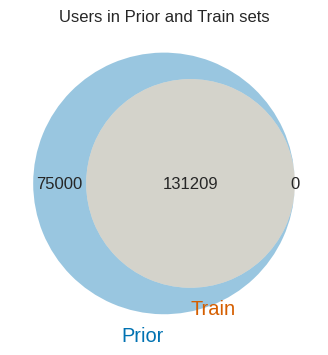


Total unique values across all datasets: 206209

Total unique values in each dataset:
Prior: 206209
Train: 131209

Intersection statistics:
Values present in Prior and Train: 131209 (63.63%)

Exclusive value statistics:
Values present only in Prior: 75000 (36.37%)
Values present only in Train: 0 (0.00%)


In [11]:
compare_series(
    df_orders[df_orders.eval_set == 'prior'].user_id,
    df_orders[df_orders.eval_set == 'train'].user_id,
    labels=['Prior', 'Train'],
    title='Users in Prior and Train sets'
)

In [12]:
df_aux = df_orders.groupby(['user_id', 'eval_set']).size().unstack().fillna(0).astype(int)
for col in df_aux.columns:
    print(f"Number of times a user appears in {col} set:")
    display(df_aux[col].value_counts().sort_index())

Number of times a user appears in prior set:


prior
3     23986
4     19590
5     16165
6     13850
7     11700
      ...  
95       67
96       54
97       50
98       47
99     1374
Name: count, Length: 97, dtype: int64

Number of times a user appears in train set:


train
0     75000
1    131209
Name: count, dtype: int64

In [13]:
print('Percentage of missing values in each column by eval_set:')
(
    df_orders
    .groupby('eval_set')
    .apply(
        lambda x: pd.Series({col: x[col].isnull().mean() for col in x.columns if col != 'eval_set'}),
        include_groups=False
        )
    .T
)

Percentage of missing values in each column by eval_set:


eval_set,prior,train
order_id,0.000000,0.0
user_id,0.000000,0.0
order_number,0.000000,0.0
order_dow,0.000000,0.0
order_hour_of_day,0.000000,0.0
days_since_prior_order,0.064142,0.0


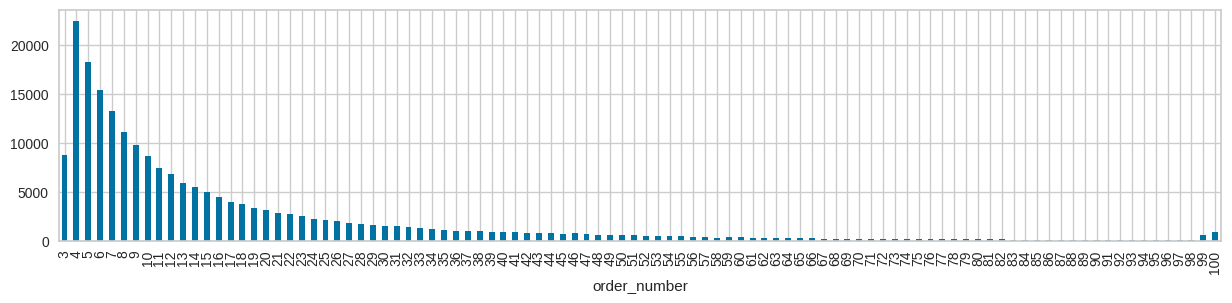

In [14]:
df_orders.groupby('user_id').order_number.max().value_counts().sort_index().plot(kind='bar', figsize=(15, 3));

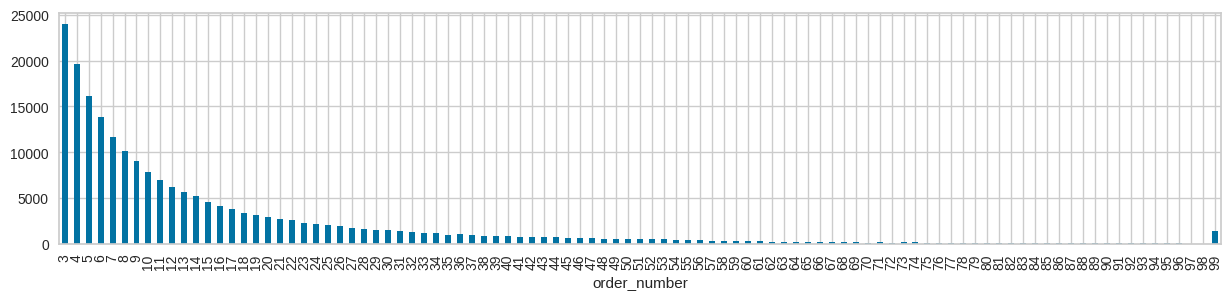

In [15]:
df_orders[df_orders.eval_set == 'prior'].groupby('user_id').order_number.max().value_counts().sort_index().plot(kind='bar', figsize=(15, 3));

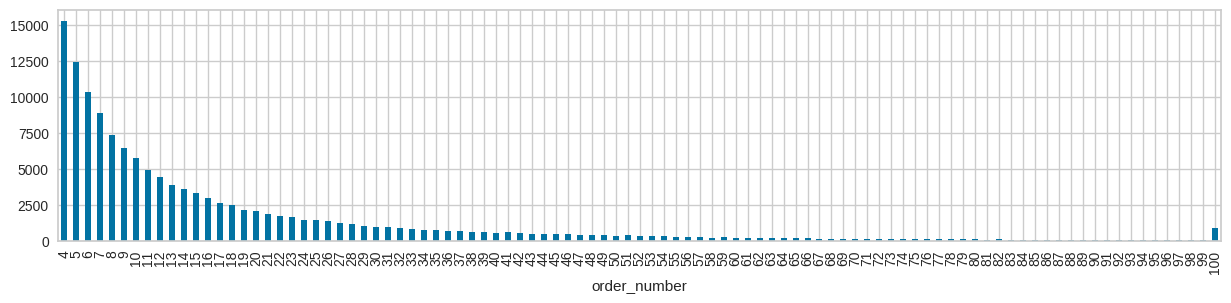

In [16]:
df_orders[df_orders.eval_set == 'train'].groupby('user_id').order_number.max().value_counts().sort_index().plot(kind='bar', figsize=(15, 3));

##### Number of orders per user

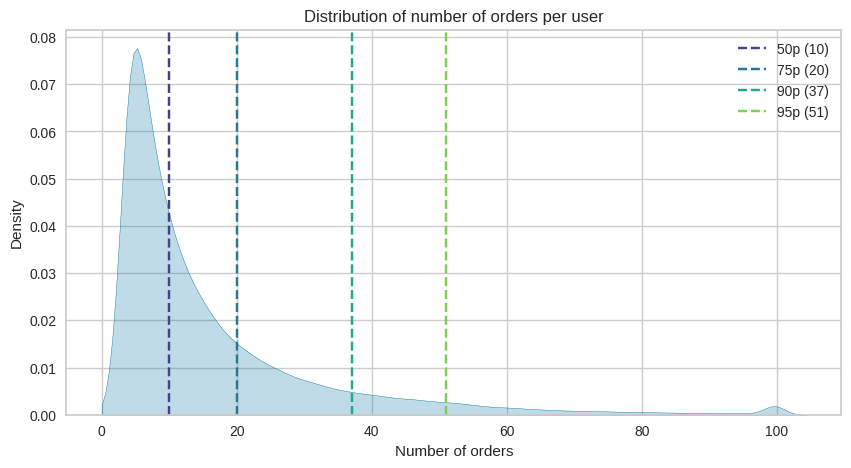

In [17]:
plot_stats(df_orders.groupby('user_id').size(), 'Number of orders', 'Distribution of number of orders per user')

##### Day of the week

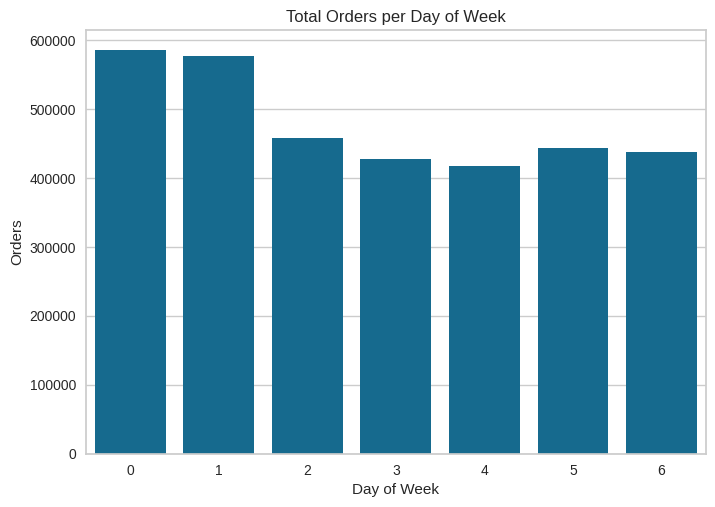

In [18]:
sns.barplot(x=df_orders.order_dow.value_counts().index, y=df_orders.order_dow.value_counts().values)
plt.xlabel('Day of Week')
plt.ylabel('Orders')
plt.title('Total Orders per Day of Week');

##### Day of the week

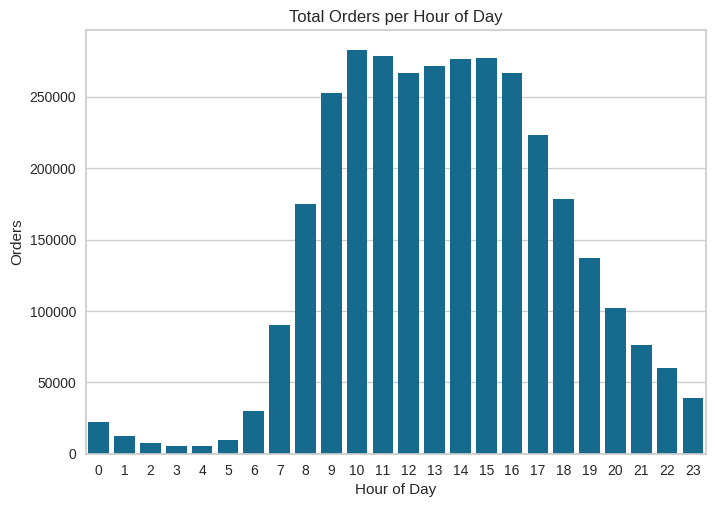

In [19]:
sns.barplot(x=df_orders.order_hour_of_day.value_counts().index, y=df_orders.order_hour_of_day.value_counts().values)
plt.xlabel('Hour of Day')
plt.ylabel('Orders')
plt.title('Total Orders per Hour of Day');

##### Days since prior order

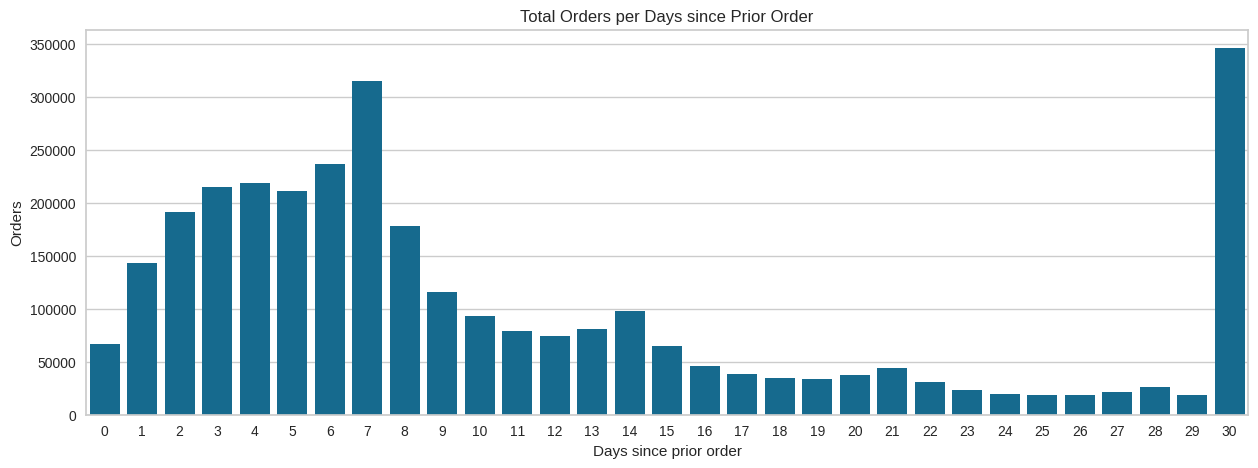

In [20]:
plt.figure(figsize=(15, 5))
sns.barplot(x=df_orders.days_since_prior_order.value_counts().index.astype(int), y=df_orders.days_since_prior_order.value_counts().values)
plt.xlabel('Days since prior order')
plt.ylabel('Orders')
plt.title('Total Orders per Days since Prior Order');

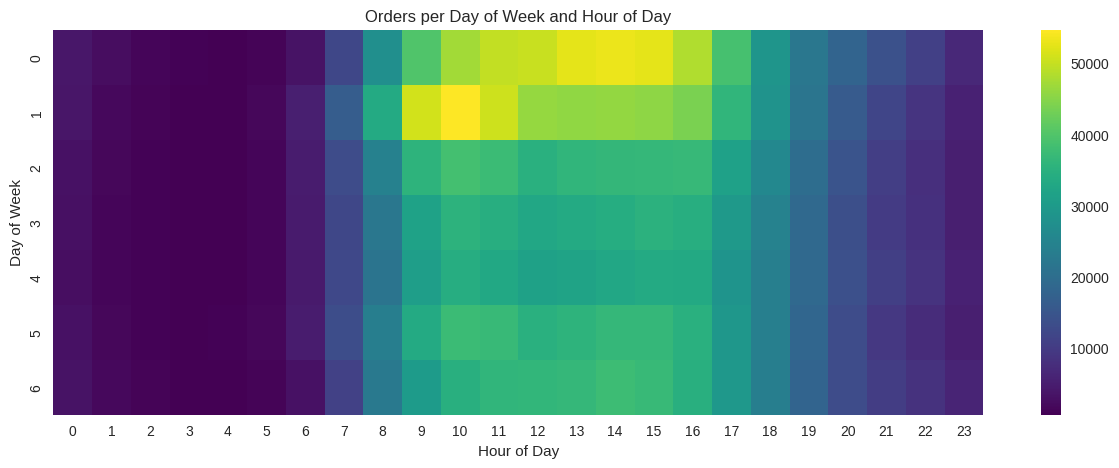

In [21]:
# Heatmap of orders per day of week and hour of day
heatmap = df_orders.pivot_table(index='order_dow', columns='order_hour_of_day', values='order_id', aggfunc='count')
plt.figure(figsize=(15, 5))
sns.heatmap(heatmap, cmap='viridis', linecolor='white', linewidth=0)
plt.title('Orders per Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week');

### Order items

In [22]:
del df_orders

In [23]:
df_order_products = conn.execute("SELECT * FROM order_products").fetchdf()
df_order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
33819101,3421063,14233,3,1
33819102,3421063,35548,4,1
33819103,3421070,35951,1,1
33819104,3421070,16953,2,1


##### Item count

In [24]:
item_counts_per_order_1 = df_order_products.groupby('order_id').size().sort_index()
item_counts_per_order_2 = df_order_products.groupby('order_id').add_to_cart_order.max().sort_index()

assert item_counts_per_order_1.equals(item_counts_per_order_2)

item_counts_per_order = item_counts_per_order_1

In [25]:
df_order_products.add_to_cart_order.describe().drop('count')

mean      8.367738
std       7.139540
min       1.000000
25%       3.000000
50%       6.000000
75%      11.000000
max     145.000000
Name: add_to_cart_order, dtype: float64

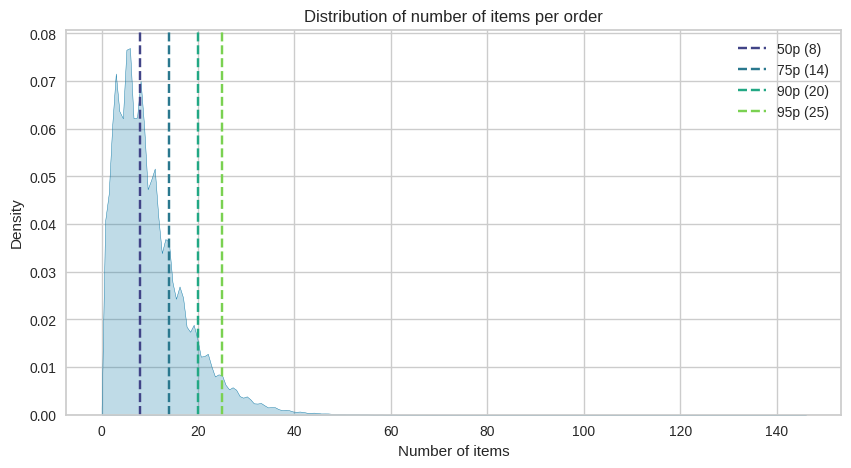

In [26]:
plot_stats(item_counts_per_order, 'Number of items', 'Distribution of number of items per order')

##### Reorder rate

In [27]:
reorder_rate = df_order_products.groupby('product_id').reordered.mean().mul(100)

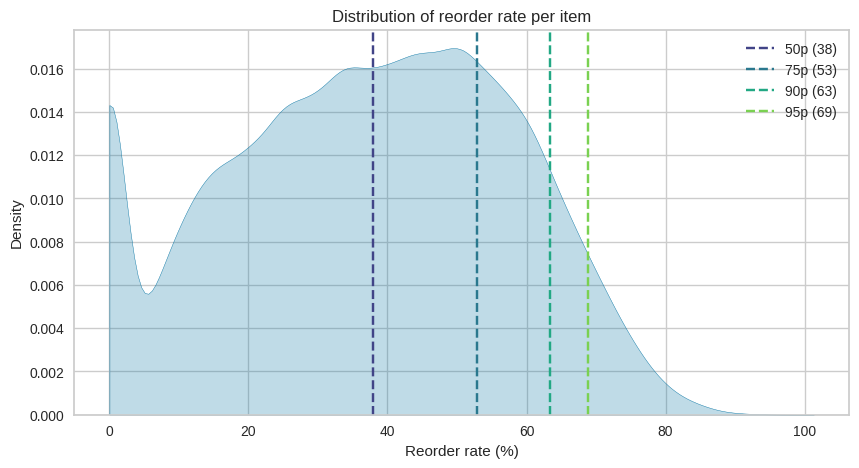

In [28]:
plot_stats(reorder_rate, 'Reorder rate (%)', 'Distribution of reorder rate per item')

In [29]:
del df_order_products

# Customer Segmentation

In [30]:
query = f"""
    WITH
        user_metrics AS (
            SELECT
                user_id,
                AVG(order_hour_of_day) AS avg_order_hour,
                MEDIAN(days_since_prior_order) AS median_days_between_orders,
                AVG(order_dow) AS avg_order_dow,
                MAX(order_number) AS total_orders
            FROM
                orders
            WHERE
                eval_set = 'prior'
            GROUP BY
                user_id
        ),
        product_metrics AS (
            SELECT
                o.user_id,
                COUNT(DISTINCT o.order_id) AS num_orders,
                COUNT(DISTINCT p.product_id) AS num_products,
                COUNT(p.product_id) / COUNT(DISTINCT o.order_id) AS avg_products_per_order,
                COUNT(p.product_id) AS total_products,
                MAX(oi.add_to_cart_order) AS max_order_size,
                CAST(SUM(oi.reordered) AS INT) AS total_reordered,
                SUM(oi.reordered) / COUNT(DISTINCT p.product_id) * 100 AS reorder_rate
            FROM
                orders o
            JOIN
                order_products oi ON o.order_id = oi.order_id
            JOIN
                products p ON oi.product_id = p.product_id
            WHERE
                eval_set = 'prior'
            GROUP BY
                o.user_id
        )
    SELECT
        um.user_id,
        um.total_orders,
        um.avg_order_hour,
        um.median_days_between_orders,
        um.avg_order_dow,
        pm.num_orders,
        pm.num_products,
        pm.avg_products_per_order,
        pm.total_products,
        pm.max_order_size,
        pm.total_reordered,
        pm.reorder_rate
    FROM
        user_metrics um
    JOIN
        product_metrics pm ON um.user_id = pm.user_id
    ORDER BY
        um.user_id
"""


In [31]:
df_segmentation = conn.execute(query).fetchdf()
df_segmentation

,user_id,total_orders,avg_order_hour,median_days_between_orders,avg_order_dow,num_orders,num_products,avg_products_per_order,total_products,max_order_size,total_reordered,reorder_rate
0,1,10,10.300000,20.0,2.500000,10,18,5.900000,59,9,41,227.777778
1,2,14,10.571429,13.0,2.142857,14,102,13.928571,195,26,93,91.176471
2,3,12,16.416667,11.0,1.083333,12,33,7.333333,88,11,55,166.666667
3,4,5,12.600000,17.0,4.800000,5,17,3.600000,18,7,1,5.882353
4,5,4,16.000000,11.0,1.750000,4,23,9.250000,37,12,14,60.869565
...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,14.333333,20.0,3.666667,3,24,10.666667,32,17,8,33.333333
206205,206206,67,16.731343,3.0,2.477612,67,150,4.253731,285,24,135,90.000000
206206,206207,16,12.500000,8.0,2.562500,16,92,13.937500,223,25,131,142.391304
206207,206208,49,14.265306,7.0,2.653061,49,198,13.816327,677,28,479,241.919192


## Feature Analysis

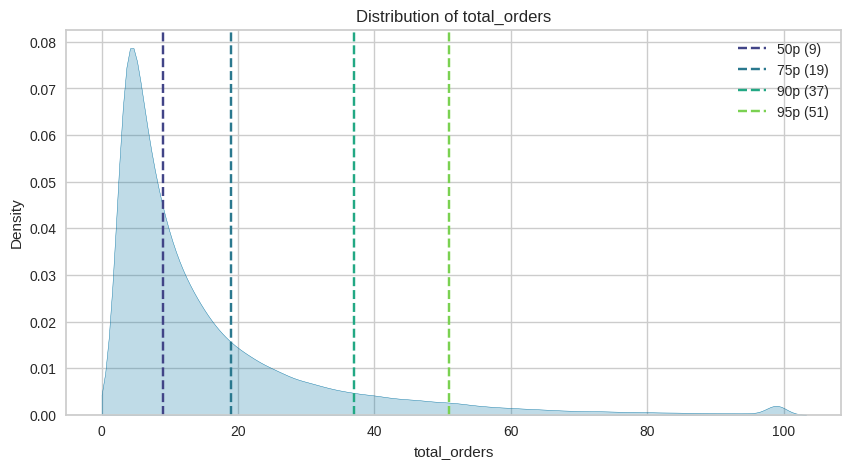

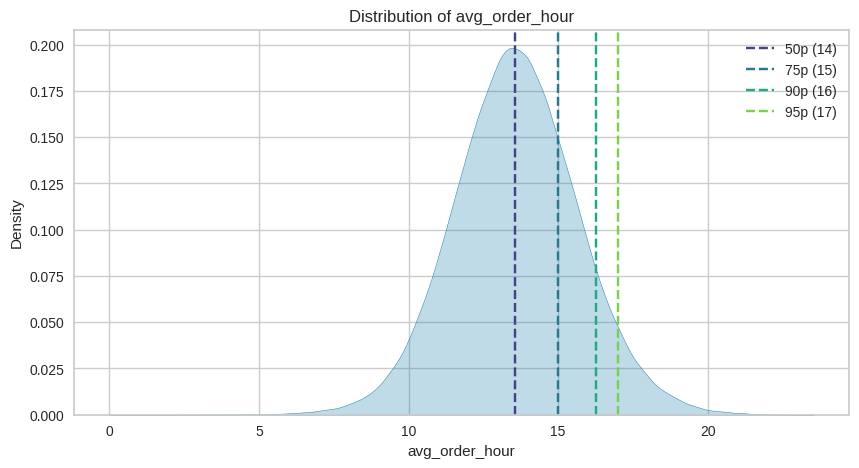

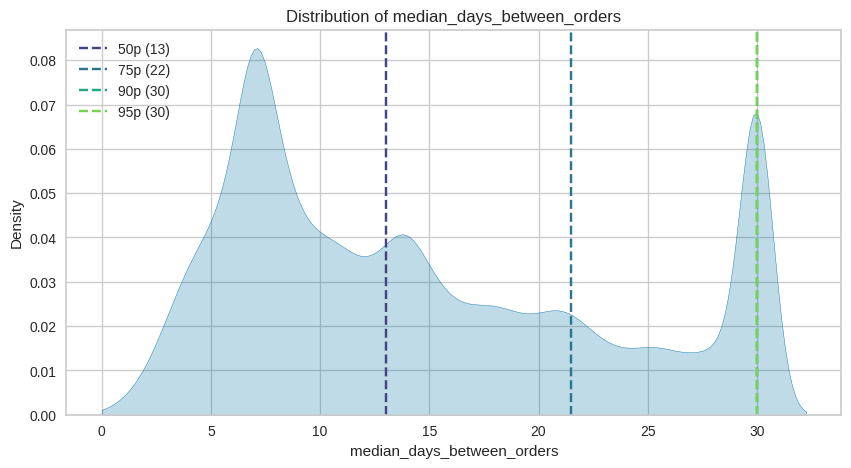

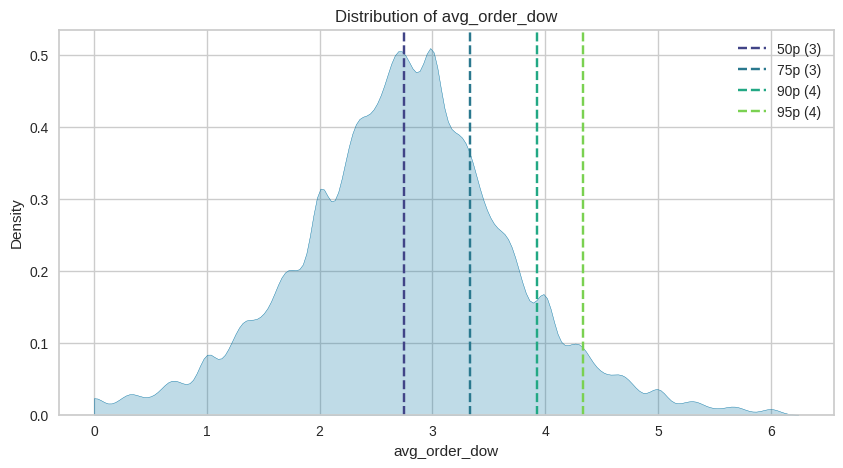

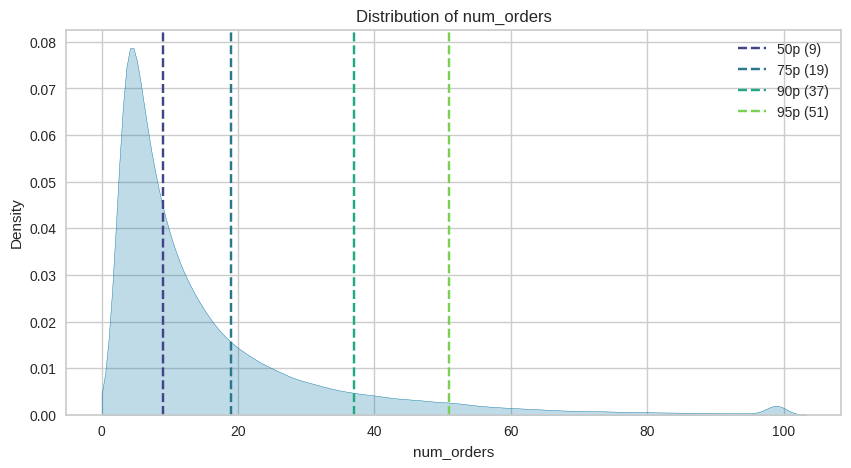

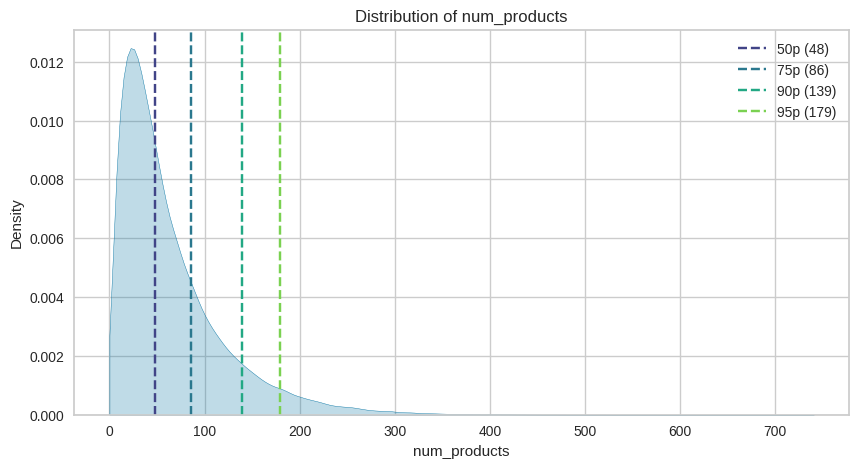

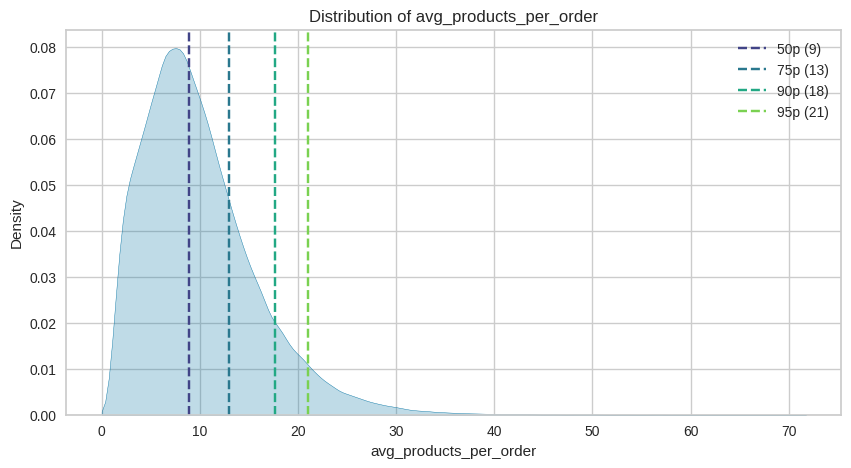

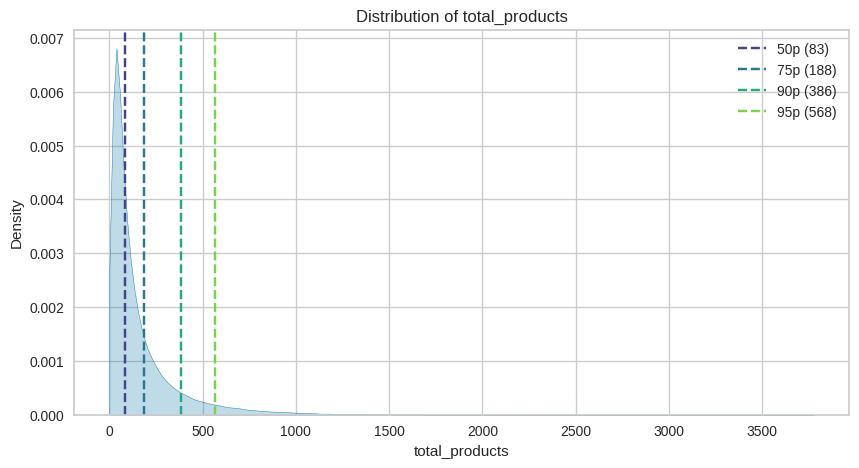

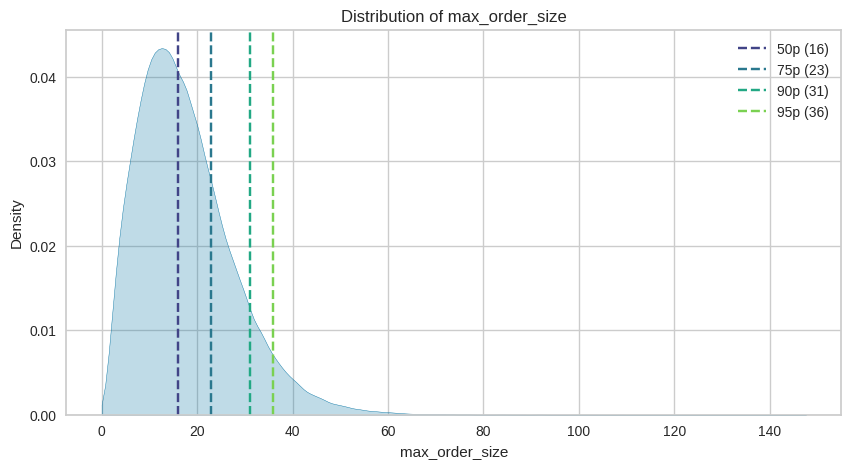

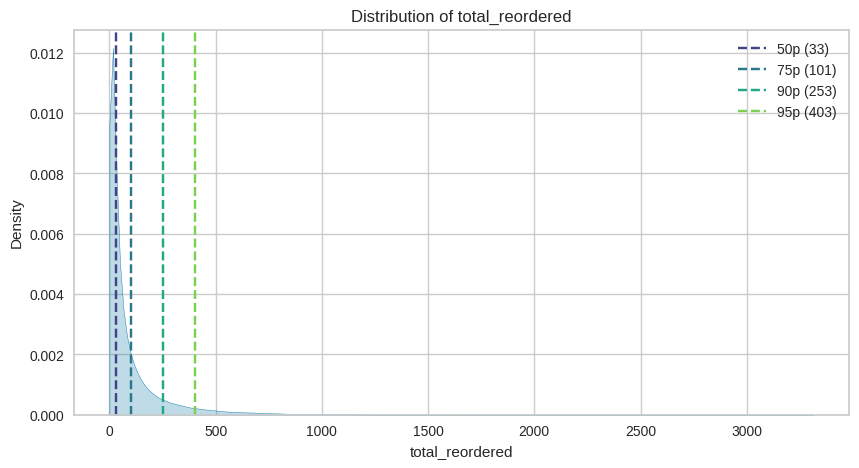

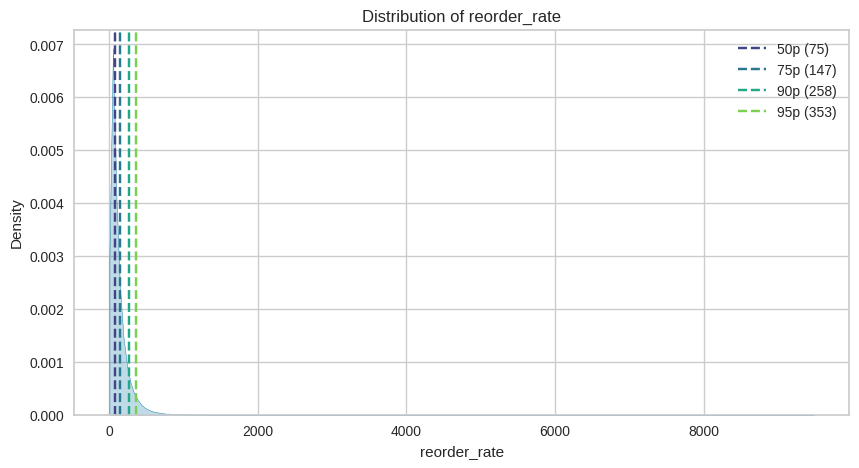

In [32]:
for col in df_segmentation.columns:
    if col == 'user_id':
        continue
    if df_segmentation[col].dtype == 'object':
        volume = df_segmentation[col].value_counts(normalize=True)

        plt.figure(figsize=(8, 6))
        sns.barplot(x=volume.index, y=volume.values)
        plt.title(f'{col}')
        plt.show()
    else:
        plot_stats(df_segmentation[col], col, f'Distribution of {col}')

## Feature Engineering

Mem. usage decreased to  5.51 Mb (69.6% reduction)


array([[<Axes: title={'center': 'total_orders'}>,
        <Axes: title={'center': 'avg_order_hour'}>,
        <Axes: title={'center': 'median_days_between_orders'}>],
       [<Axes: title={'center': 'avg_order_dow'}>,
        <Axes: title={'center': 'num_orders'}>,
        <Axes: title={'center': 'num_products'}>],
       [<Axes: title={'center': 'avg_products_per_order'}>,
        <Axes: title={'center': 'total_products'}>,
        <Axes: title={'center': 'max_order_size'}>],
       [<Axes: title={'center': 'total_reordered'}>,
        <Axes: title={'center': 'reorder_rate'}>, <Axes: >]], dtype=object)

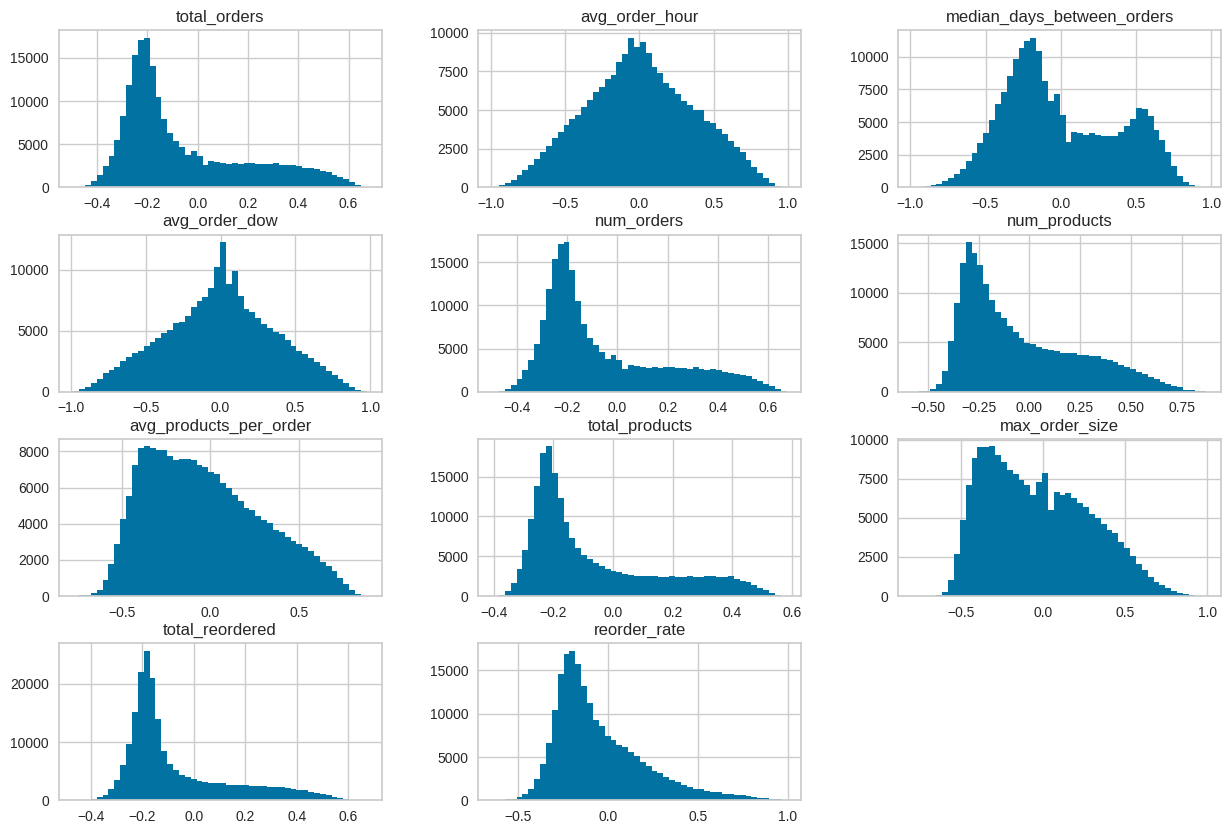

In [33]:
# Standardize the data
scaler = StandardScaler()
norm = Normalizer()

df_segmentation = reduce_mem_usage(df_segmentation.set_index('user_id'))
data_scaled = scaler.fit_transform(df_segmentation)
data_scaled = norm.fit_transform(data_scaled).astype(np.float16)

pd.DataFrame(data_scaled, columns=df_segmentation.columns).hist(figsize=(15, 10), bins=50)

## Feature decomposition

In [34]:
pca = PCA(n_components=4)

data_pca = pca.fit_transform(data_scaled)
data_pca

array([[-0.42234615, -0.31923768, -0.66703645,  0.08960483],
       [ 0.53286477,  0.37531928, -0.76411846,  0.09909726],
       [-0.15665724, -0.11870895,  0.19201947, -0.89953438],
       ...,
       [ 0.89473252,  0.22201249, -0.33550916,  0.08449735],
       [ 1.06242358, -0.1043792 ,  0.05130149, -0.06469224],
       [-0.33671611,  0.6736931 , -0.04146299,  0.16006745]])

## Clustering

### Elbow method

Elbow method using distortion metric


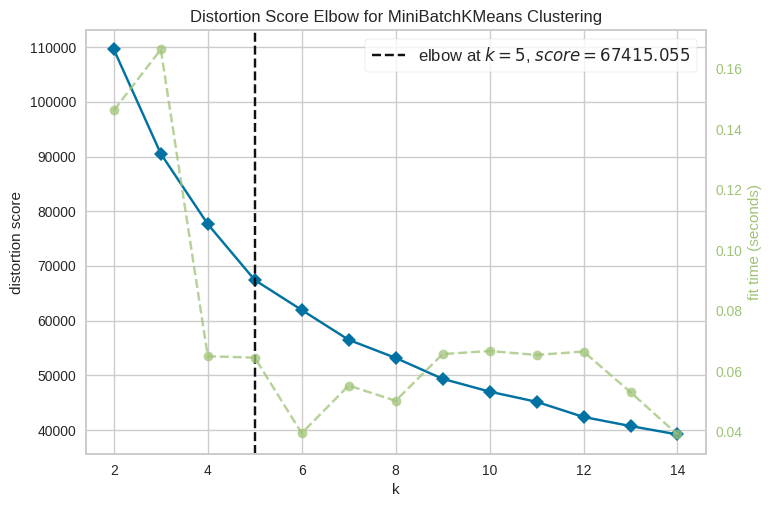

Elbow method using silhouette metric


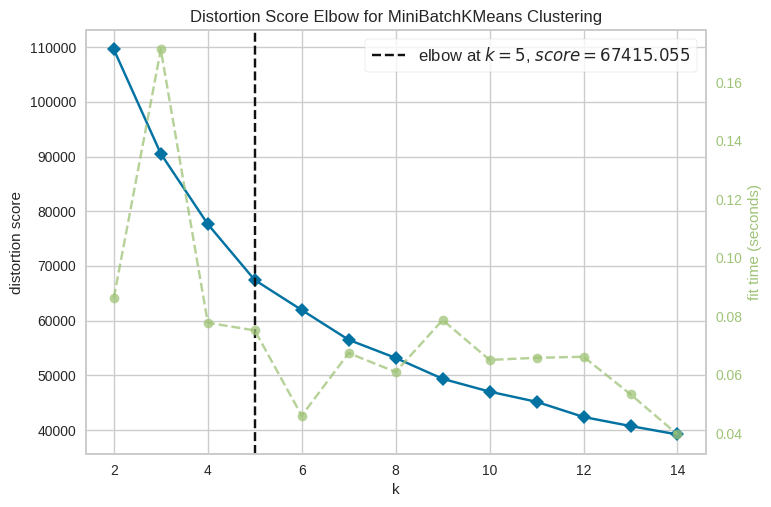

Elbow method using calinski_harabasz metric


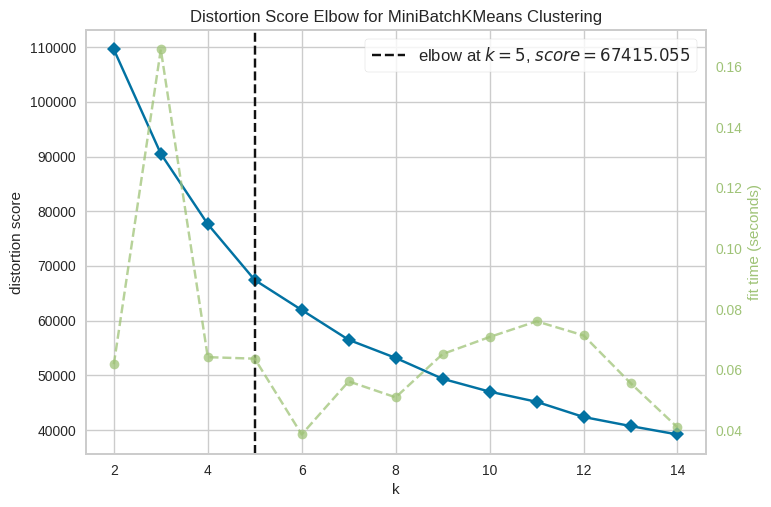

<Figure size 800x550 with 0 Axes>

In [35]:
model = MiniBatchKMeans(random_state=42)
for method in ['distortion', 'silhouette', 'calinski_harabasz']:

    print(f"Elbow method using {method} metric")
    visualizer = KElbowVisualizer(model, k=(2,15), method=method)

    visualizer.fit(data_pca)
    visualizer.show(clear_figure=True);

### Clustering diagram

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.493 seconds.
K=3 fitted in 0.591 seconds.
K=4 fitted in 0.791 seconds.
K=5 fitted in 0.881 seconds.
K=6 fitted in 0.997 seconds.
K=7 fitted in 1.125 seconds.
K=8 fitted in 1.263 seconds.
K=9 fitted in 1.382 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

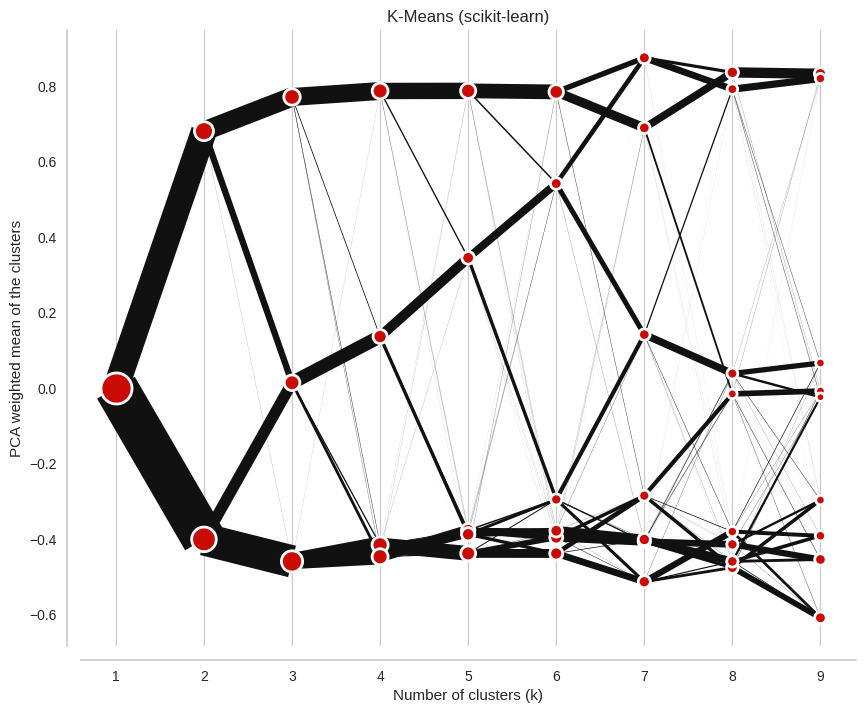

In [36]:
cgram = Clustergram(range(1, 10), n_init=1000, method='minibatchkmeans')
cgram.fit(data_pca)

ax = cgram.plot(
    figsize=(10, 8),
    )
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

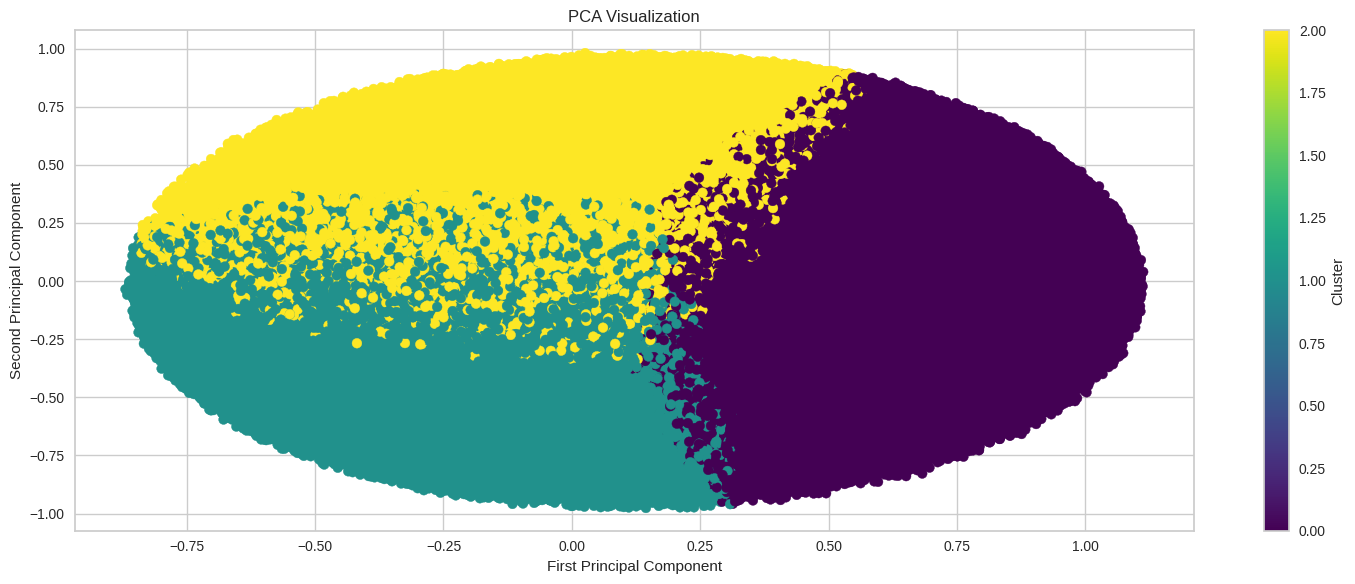

In [37]:
model = MiniBatchKMeans(n_clusters=3, random_state=42)
labels = model.fit_predict(data_pca)

plot_pca(data_scaled, model.labels_)

In [38]:
df_segmentation['cluster'] = model.labels_
df_segmentation['cluster'].value_counts()

cluster
1    78829
0    63927
2    63453
Name: count, dtype: int64

In [39]:
df_segmentation.groupby('cluster').mean().T.style.background_gradient(axis=1).format("{:.2f}")

cluster,0,1,2
total_orders,32.55,9.23,6.40
avg_order_hour,13.45,13.66,13.63
median_days_between_orders,8.22,15.09,20.92
avg_order_dow,2.78,3.16,2.22
num_orders,32.55,9.23,6.40
num_products,124.22,28.34,49.36
avg_products_per_order,12.65,5.74,12.47
total_products,368.55,50.07,77.66
max_order_size,25.28,9.89,19.63
total_reordered,244.32,21.73,28.29


### Cluster Descriptions

**Cluster 0: High Engagement Shoppers**:

This cluster includes shoppers who frequently place large orders with a high total number of products and a significant reorder rate, indicating strong brand loyalty and consistent shopping habits.

**Cluster 1: Low Engagement Shoppers**:

Shoppers in this cluster place fewer orders, with smaller average order sizes and longer intervals between orders. They have a lower total product count and reorder rate, showing infrequent shopping and less brand loyalty.

**Cluster 2: Moderate Engagement Shoppers**:

This cluster represents shoppers who place orders less frequently but with a larger number of products per order. They have the longest intervals between orders and show moderate total product count and reorder rates, indicating periodic bulk shopping with selective product loyalty.

In [ ]:
del df_segmentation
del data_scaled
del data_pca

# Inventory Management

In [5]:
if 'full_table' not in conn.execute("SHOW TABLES").fetch_df().name.values:
    # Step 1: Query and load each table into pandas DataFrames
    orders_df = conn.execute("SELECT * FROM orders WHERE eval_set = 'prior'").fetchdf()
    order_products_df = conn.execute("SELECT order_id, product_id, add_to_cart_order, reordered FROM order_products").fetchdf()
    products_df = conn.execute("SELECT product_id, product_name, aisle_id, department_id FROM products").fetchdf()
    aisles_df = conn.execute("SELECT aisle_id, aisle FROM aisles").fetchdf()
    departments_df = conn.execute("SELECT department_id, department FROM departments").fetchdf()
    print("Data loaded successfully")

    # Step 2: Perform the joins in pandas
    merged_df = orders_df.merge(order_products_df, on='order_id')
    print('Merged orders and order_products')
    merged_df = merged_df.merge(products_df, on='product_id')
    print('Merged products')
    merged_df = merged_df.merge(aisles_df, on='aisle_id')
    print('Merged aisles')
    merged_df = merged_df.merge(departments_df, on='department_id')
    print('Merged departments')

    # Step 3: Select the necessary columns
    result_df = reduce_mem_usage(merged_df)

    # Step 4: Save the result to a CSV file
    result_df.to_csv('full_table.csv', index=False)

    # Write table to DuckDB
    create_and_load_table(conn, 'full_table.csv', 'full_table')

df_full = conn.sql(
    """
    SELECT
        user_id,
        product_id,
        order_id,
        order_number,
        aisle_id,
        department_id,
        add_to_cart_order,
        order_dow,
        days_since_prior_order,
        reordered
    FROM
        full_table
    """
    ).df()

In [6]:
df_full = reduce_mem_usage(df_full)
df_full

Mem. usage decreased to 680.50 Mb (45.0% reduction)


,user_id,product_id,order_id,order_number,aisle_id,department_id,add_to_cart_order,order_dow,days_since_prior_order,reordered
0,1,196,2539329,1,77,7,1,2,0.0,0
1,1,14084,2539329,1,91,16,2,2,0.0,0
2,1,12427,2539329,1,23,19,3,2,0.0,0
3,1,26088,2539329,1,23,19,4,2,0.0,0
4,1,26405,2539329,1,54,17,5,2,0.0,0
...,...,...,...,...,...,...,...,...,...,...
32434484,206209,14197,2977660,13,9,9,5,1,7.0,1
32434485,206209,38730,2977660,13,3,19,6,1,7.0,0
32434486,206209,31477,2977660,13,3,19,7,1,7.0,0
32434487,206209,6567,2977660,13,3,19,8,1,7.0,0


## Product Features

In [7]:
df_full = df_full.set_index(['user_id', 'product_id'])
df_full['user_buy_product_times'] = df_full.groupby(['user_id', 'product_id']).size()

In [8]:
prd_feats = df_full.reset_index().groupby('product_id').agg(
    prd_num_orders=('order_id', 'nunique'),
    prd_num_reorders=('reordered', 'sum'),
    prd_reorder_rate=('reordered', 'mean'),
    prd_avg_add_to_cart_order=('add_to_cart_order', 'mean'),
    prd_unique_users=('user_id', 'nunique'),
    prd_avg_buy_product_times=('user_buy_product_times', 'mean'),
    prd_max_buy_product_times=('user_buy_product_times', 'max'),
    prd_min_buy_product_times=('user_buy_product_times', 'min'),
    prd_avg_order_number=('order_number', 'mean'),
    prd_avg_order_dow=('order_dow', 'mean'),
    prd_avg_days_since_prior_order=('days_since_prior_order', 'mean')
)

prd_feats = reduce_mem_usage(prd_feats)
prd_feats

Mem. usage decreased to  1.42 Mb (65.9% reduction)


,prd_num_orders,prd_num_reorders,prd_reorder_rate,prd_avg_add_to_cart_order,prd_unique_users,prd_avg_buy_product_times,prd_max_buy_product_times,prd_min_buy_product_times,prd_avg_order_number,prd_avg_order_dow,prd_avg_days_since_prior_order
product_id,,,,,,,,,,,
1,1852,1136,0.612793,5.800781,716,8.382812,37,1,19.390625,2.775391,9.882812
2,90,12,0.133057,9.890625,78,1.489258,6,1,25.671875,2.921875,10.132812
3,277,203,0.732910,6.414062,74,13.179688,40,1,17.343750,2.736328,9.914062
4,329,147,0.447021,9.507812,182,3.736328,18,1,9.023438,2.683594,12.945312
5,15,9,0.600098,6.468750,6,4.199219,7,1,8.929688,2.732422,11.601562
...,...,...,...,...,...,...,...,...,...,...,...
49684,9,1,0.111023,4.332031,8,1.221680,2,1,4.777344,4.222656,10.554688
49685,49,6,0.122009,9.570312,43,1.245117,2,1,13.445312,2.755859,11.875000
49686,120,84,0.700195,7.500000,36,12.031250,25,1,19.312500,2.882812,8.023438


## Aisle features

In [9]:
aisles_feats = df_full.reset_index().groupby('aisle_id').agg(
    ai_num_orders=('order_id', 'nunique'),
    ai_num_reorders=('reordered', 'sum'),
    ai_reorder_rate=('reordered', 'mean'),
    ai_avg_add_to_cart_order=('add_to_cart_order', 'mean'),
    ai_unique_users=('user_id', 'nunique'),
    ai_avg_buy_product_times=('user_buy_product_times', 'mean'),
    ai_max_buy_product_times=('user_buy_product_times', 'max'),
    ai_min_buy_product_times=('user_buy_product_times', 'min'),
    ai_avg_order_number=('order_number', 'mean'),
    ai_avg_order_dow=('order_dow', 'mean'),
    ai_avg_days_since_prior_order=('days_since_prior_order', 'mean')
)

aisles_feats = reduce_mem_usage(aisles_feats)
aisles_feats

Mem. usage decreased to  0.00 Mb (67.4% reduction)


,ai_num_orders,ai_num_reorders,ai_reorder_rate,ai_avg_add_to_cart_order,ai_unique_users,ai_avg_buy_product_times,ai_max_buy_product_times,ai_min_buy_product_times,ai_avg_order_number,ai_avg_order_dow,ai_avg_days_since_prior_order
aisle_id,,,,,,,,,,,
1,63115,42912,0.597168,8.171875,20711,8.218750,89,1,17.140625,2.691406,10.335938
2,77171,40365,0.489014,9.273438,31222,5.238281,74,1,16.750000,2.894531,10.570312
3,278151,272922,0.598145,9.570312,63592,7.441406,85,1,17.562500,2.623047,9.976562
4,165541,98243,0.489990,10.164062,53892,4.644531,51,1,15.070312,2.685547,11.414062
5,58390,17542,0.281006,10.296875,32312,2.406250,56,1,15.460938,2.730469,10.679688
...,...,...,...,...,...,...,...,...,...,...,...
130,145294,79003,0.500000,9.273438,54068,5.195312,68,1,17.562500,2.744141,10.328125
131,227113,120803,0.452881,10.359375,73124,4.070312,47,1,16.140625,2.707031,10.789062
132,5837,1308,0.212036,8.992188,4227,1.951172,21,1,15.414062,2.875000,10.570312


## Department features

In [10]:
depart_feats = df_full.reset_index().groupby('department_id').agg(
    dpt_num_orders=('order_id', 'nunique'),
    dpt_num_reorders=('reordered', 'sum'),
    dpt_reorder_rate=('reordered', 'mean'),
    dpt_avg_add_to_cart_order=('add_to_cart_order', 'mean'),
    dpt_unique_users=('user_id', 'nunique'),
    dpt_avg_buy_product_times=('user_buy_product_times', 'mean'),
    dpt_max_buy_product_times=('user_buy_product_times', 'max'),
    dpt_min_buy_product_times=('user_buy_product_times', 'min'),
    dpt_avg_order_number=('order_number', 'mean'),
    dpt_avg_order_dow=('order_dow', 'mean'),
    dpt_avg_days_since_prior_order=('days_since_prior_order', 'mean')
)

depart_feats = reduce_mem_usage(depart_feats)
depart_feats

Mem. usage decreased to  0.00 Mb (68.2% reduction)


,dpt_num_orders,dpt_num_reorders,dpt_reorder_rate,dpt_avg_add_to_cart_order,dpt_unique_users,dpt_avg_buy_product_times,dpt_max_buy_product_times,dpt_min_buy_product_times,dpt_avg_order_number,dpt_avg_order_dow,dpt_avg_days_since_prior_order
department_id,,,,,,,,,,,
1,1181018,1211890,0.541992,8.992188,163233,6.011719,92,1,15.460938,2.789062,10.898438
2,35056,14806,0.407959,8.281250,17875,4.773438,58,1,17.281250,2.851562,10.242188
3,881556,739188,0.627930,8.085938,140612,8.468750,92,1,17.187500,2.742188,10.382812
4,2409320,6160710,0.649902,8.023438,193237,8.578125,98,1,17.812500,2.683594,10.187500
5,84689,87595,0.569824,5.429688,15798,8.507812,98,1,15.218750,3.162109,9.484375
6,221537,99416,0.368896,9.945312,76583,3.738281,59,1,16.437500,2.691406,10.492188
7,1457351,1757892,0.652832,6.976562,172795,9.859375,99,1,17.218750,2.806641,10.367188
8,59282,58760,0.601074,7.718750,14986,7.183594,61,1,15.343750,2.935547,11.062500
9,597862,399581,0.460938,10.210938,124820,4.222656,69,1,15.898438,2.691406,10.945312


## Feature analysis

In [11]:
gc.collect()

40

: 

In [12]:
df_feats = df_full.reset_index().merge(prd_feats, left_on='product_id', right_index=True, how='left')
df_feats = df_feats.merge(aisles_feats, left_on='aisle_id', right_index=True, how='left')
df_feats = df_feats.merge(depart_feats, left_on='department_id', right_index=True, how='left')
df_feats

In [ ]:
df_feats = reduce_mem_usage(df_feats)
df_feats.to_parquet('features.parquet', index=False)
conn.execute(f"CREATE TABLE features AS SELECT * FROM read_parquet('features.parquet')")

Mem. usage decreased to 2474.56 Mb (8.0% reduction)


/home/pedro/my_project_dir/ambev/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/pedro/my_project_dir/ambev/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,user_id,product_id,order_id,order_number,aisle_id,department_id,add_to_cart_order,order_dow,days_since_prior_order,reordered,...,ai_unique_users,ai_avg_buy_product_times,ai_max_buy_product_times,dpt_num_orders,dpt_num_reorders,dpt_reorder_rate,dpt_avg_add_to_cart_order,dpt_unique_users,dpt_avg_buy_product_times,dpt_max_buy_product_times
0,1,196,2539329,1,77,7,1,2,NaN,0,...,63506,9.156250,97,1457351,1757892,0.653320,6.976562,172795,9.859375,99
1,1,14084,2539329,1,91,16,2,2,NaN,0,...,96326,10.992188,90,2177338,3627221,0.669922,7.496094,190565,10.062500,99
2,1,12427,2539329,1,23,19,3,2,NaN,0,...,44854,6.925781,67,1391447,1657973,0.574219,9.187500,174219,6.765625,93
3,1,26088,2539329,1,23,19,4,2,NaN,0,...,44854,6.925781,67,1391447,1657973,0.574219,9.187500,174219,6.765625,93
4,1,26405,2539329,1,54,17,5,2,NaN,0,...,60265,5.363281,88,470780,297075,0.402100,8.492188,111608,3.792969,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,14197,2977660,13,9,9,5,1,7.0,1,...,68554,4.382812,69,597862,399581,0.461182,10.210938,124820,4.222656,69
32434485,206209,38730,2977660,13,3,19,6,1,7.0,0,...,63592,7.441406,85,1391447,1657973,0.574219,9.187500,174219,6.765625,93
32434486,206209,31477,2977660,13,3,19,7,1,7.0,0,...,63592,7.441406,85,1391447,1657973,0.574219,9.187500,174219,6.765625,93
32434487,206209,6567,2977660,13,3,19,8,1,7.0,0,...,63592,7.441406,85,1391447,1657973,0.574219,9.187500,174219,6.765625,93


In [ ]:
df_feats = pd.read_parquet('features.parquet')
df_feats

/home/pedro/my_project_dir/ambev/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/pedro/my_project_dir/ambev/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,user_id,product_id,order_id,order_number,aisle_id,department_id,add_to_cart_order,order_dow,days_since_prior_order,reordered,...,ai_unique_users,ai_avg_buy_product_times,ai_max_buy_product_times,dpt_num_orders,dpt_num_reorders,dpt_reorder_rate,dpt_avg_add_to_cart_order,dpt_unique_users,dpt_avg_buy_product_times,dpt_max_buy_product_times
0,1,196,2539329,1,77,7,1,2,NaN,0,...,63506,9.156250,97,1457351,1757892,0.653320,6.976562,172795,9.859375,99
1,1,14084,2539329,1,91,16,2,2,NaN,0,...,96326,10.992188,90,2177338,3627221,0.669922,7.496094,190565,10.062500,99
2,1,12427,2539329,1,23,19,3,2,NaN,0,...,44854,6.925781,67,1391447,1657973,0.574219,9.187500,174219,6.765625,93
3,1,26088,2539329,1,23,19,4,2,NaN,0,...,44854,6.925781,67,1391447,1657973,0.574219,9.187500,174219,6.765625,93
4,1,26405,2539329,1,54,17,5,2,NaN,0,...,60265,5.363281,88,470780,297075,0.402100,8.492188,111608,3.792969,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,14197,2977660,13,9,9,5,1,7.0,1,...,68554,4.382812,69,597862,399581,0.461182,10.210938,124820,4.222656,69
32434485,206209,38730,2977660,13,3,19,6,1,7.0,0,...,63592,7.441406,85,1391447,1657973,0.574219,9.187500,174219,6.765625,93
32434486,206209,31477,2977660,13,3,19,7,1,7.0,0,...,63592,7.441406,85,1391447,1657973,0.574219,9.187500,174219,6.765625,93
32434487,206209,6567,2977660,13,3,19,8,1,7.0,0,...,63592,7.441406,85,1391447,1657973,0.574219,9.187500,174219,6.765625,93
